In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from itertools import cycle
import random
from collections import Counter
from tqdm import tqdm
from vips import vipp

# Making all figures
 - Test error (PLSR & RF)
 - Clustering (DE genes) -> GO processes (done)
 - PCA (DE genes)
 

In [2]:

## ALREADY PREPROCESSED 
#### Min gene count = 0 for 15% of samples

train_fpkm = pd.read_csv("../data/BAL/train_fpkm_minfilter0_log2.csv",sep='\t',index_col=0)
train_meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

test_fpkm = pd.read_csv("../data/BAL/test_fpkm_minfilter0_log2.csv", sep='\t', index_col=0)
test_meta = pd.read_csv('../data/BAL/meta_r0.csv', sep='\t', index_col=0)


In [3]:
print test_fpkm.shape, test_meta.shape
print train_fpkm.shape, train_meta.shape

(32, 26081) (32, 2)
(95, 11957) (95, 32)


In [4]:
train_meta['sum_fpkm'] = train_fpkm.apply(lambda x: np.sum(x), axis=1)
test_meta['sum_fpkm'] = test_fpkm.apply(lambda x: np.sum(x), axis=1)

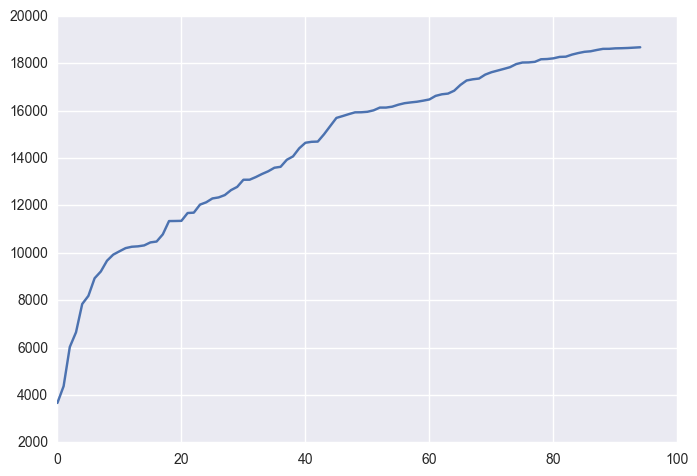

In [5]:
plt.plot(sorted(train_meta['sum_fpkm']))

In [6]:
test_meta = test_meta[test_meta['sum_fpkm'] > 15000]
train_meta = train_meta[train_meta['sum_fpkm'] > 10000]

test_fpkm =  test_fpkm.ix[test_meta.index]
train_fpkm = train_fpkm.ix[train_meta.index]

In [7]:
test_meta.shape, train_meta.shape

((31, 3), (85, 33))

## Select new
### exclude 18,19

In [8]:
to_remove = ['BAL18','BAL19']
new_index = [i for i in train_fpkm.index if not any(rem in i for rem in to_remove)]
train_fpkm = train_fpkm.ix[new_index]
train_meta = train_meta.ix[new_index]

In [9]:
train_meta['Pneum'].value_counts()

False    55
True     29
Name: Pneum, dtype: int64

In [10]:
train_meta.shape

(84, 33)

In [11]:
## ^^ good

## Reclassify

In [12]:
old_pos = train_meta[train_meta['Pneum']==True]
old_pos_bals = old_pos['BAL'].values
old_pos_bals

array(['BAL28', 'BAL38', 'BAL48', 'BAL53', 'BAL55', 'BAL64', 'BAL75',
       'BAL75', 'BAL79', 'BAL87', 'BAL87', 'BAL28', 'BAL33', 'BAL38',
       'BAL45', 'BAL46', 'BAL46', 'BAL49', 'BAL50', 'BAL51', 'BAL51',
       'BAL53', 'BAL55', 'BAL57', 'BAL67', 'BAL79', 'BAL83', 'BAL86',
       'BAL86'], dtype=object)

In [13]:
## Based on Mac's email 9/14/17
#final_pos_doc = 
f = open('../data/BAL/final_positives.txt','r').readlines()
new_pos_bals = np.array([str('BAL' + i).rstrip() for i in f if len(i)>1])

In [14]:
new_pos_bals.shape

(29,)

In [15]:
train_meta['Pneum'] = train_meta['BAL'].map(lambda x: x in new_pos_bals)
train_meta['Pneum'].value_counts()

False    55
True     29
Name: Pneum, dtype: int64

In [16]:
train_meta.shape

(84, 33)

### Change oral contaminates to negative

In [17]:
oral_bals = ['BAL' + str(i) for i in [10, 40, 51, 52, 53, 64, 70, 79]]

In [18]:
oral_meta = train_meta
bal_dict = dict(zip(oral_meta['BAL'],oral_meta['Pneum']))
oral_meta['Pneum'] = oral_meta['BAL'].map(lambda x: False if x in oral_bals else bal_dict[x])

In [19]:
oral_meta['Pneum'].value_counts()

False    64
True     20
Name: Pneum, dtype: int64

In [20]:
def geteven_xy(df, dfm, celltype, sampling='up', norm=False):
    dfm = dfm[dfm['CellType']==celltype]
    y = dfm['Pneum'].values
    df = df.ix[dfm.index]
    #    if z: df = df.apply(lambda x: zscore(x))
    genes = df.columns
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = [i for i in range(len(y)) if y[i]==False]
    
    npos = len(pos)
    nneg = len(neg)

    #print "Num positive: {}".format(len(pos))
    #print "Num negative: {}".format(len(neg))
    if sampling=='down':
        if nneg >= npos:
            neg = random.sample(neg, npos)
        else:
            pos = random.sample(pos, nneg)
    if sampling=='up':
        if nneg >= npos:
            dup_pos = list(np.random.choice(pos, nneg-npos))
            pos = pos + dup_pos ## pos+pos in case not enough in pos
    #            print "duplicated pos:", dup_pos
        else:
            neg = neg + np.random.choice(neg, npos-nneg)

    df = df.ix[(pos+neg),:]
    if norm=='zero_one': 
        for col in df.columns:
            mx = np.max(df[col])
            mn = np.min(df[col])
            df[col] = df[col].map(lambda x: (x - mn)/(mx - mn))
            
    if norm=='zscore': 
        df = df.apply(lambda x: zscore(x))

    dfm = dfm.ix[(pos+neg),:]
    X = np.array(df)
    y = dfm['Pneum'].values
    print "Num pos after sampling: {}".format(len(pos))
    print "Num neg after sampling: {}".format(len(neg))
    #y = y[pos + neg] 
    #X = X[pos + neg] 
    return X,y, genes, df, dfm

In [21]:
def run_model(celltype, n_top_genes, response='original', method='PLSR', 
                       norm=False, random_genes=False, jumble_test=False, jumble_train=False,
                       n_jumbles=20, npcs=5, n_estimators=100, sampling=False, cross_validation='LOO', zero_train=False):
      
    '''
    Retrieves training data, gets top features using cross-validation.
    Retreives test data, filters to top features, predicts.
    '''
    
    ### TRAINING
    #################
        
    print "Model = ", celltype
    print "Method = ", method
    #print "N_Top_Genes = ", n_top_genes
    print "Normalization = ", norm
    
    # Get training data
    if response=='original': dfm = train_meta
    elif response=='oral': dfm = oral_meta
    X, y, genes, df, dfm = geteven_xy(train_fpkm, train_meta, celltype=celltype, norm=norm, sampling=sampling)
    
    if jumble_train:
        print "---- Entire training set is jumbled ----\n"
        df = df.apply(np.random.permutation)
        X = np.array(df)
    if zero_train:
        df = df.apply(lambda x: x*0)
        X = np.array(df)

    # Get top features using cross-validation
    ##############
    neg_err, pos_err, Q2, neg_accuracy_train, pos_accuracy_train, feature_inds = calc_metrics(X, y, 
                            method=method, cross_validation=cross_validation, 
                            n_pcs=npcs, n_estimators=n_estimators, n_top_genes=n_top_genes)

    ## TRAIN METRICS
    print "Q Squared: {0:.2f} \n".format(Q2)
    num_neg_correct = sum([(e < 0.5) for e in neg_err])
    num_pos_correct = sum([(e < 0.5) for e in pos_err])
    
    print "\n===== Training ======"
    print "Negative: {0:.3f} ({1}/{2}) ".format(neg_accuracy_train, num_neg_correct, len(neg_err))
    print "Positive: {0:.3f} ({1}/{2}) ".format(pos_accuracy_train, num_pos_correct, len(pos_err))
    
    
    ## Get most common genes from each LOO model
    ##############
    all_top_feature_inds = [g for m in feature_inds for g in m]
    c = Counter(all_top_feature_inds)
    top_inds = [i[0] for i in c.most_common(n_top_genes)]
    top_genes_train = [genes[i] for i in top_inds]
    
    
    ## SWITCH OUT TOP GENES WITH RANDOM GENES
    ##############
    if random_genes:
        top_genes_train = np.random.choice(genes, n_top_genes)
        print "\n **Genes for testing are RANDOM** \n"

    
    ### BUILDING PREDICTIVE MODEL with top genes
    ##############
    train_spreads = col_spreads(df[top_genes_train])
    
    
    X_train = np.array(df[top_genes_train])
    y_train = np.array(dfm['Pneum'])
    
    
    ### GET TEST SET, FILTER TO HAVE ONLY TOP FEATURES
    ############
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(test_fpkm, test_meta, celltype=celltype, norm=norm, sampling=False)
    
    test_spreads = col_spreads(df_test[top_genes_train])
    X_test = np.array(df_test[top_genes_train])
    
    ### TESTING WITH ACTUAL (non-jumbled) GENES
    ###############
    print "\n===== Testing ====="
    
    if method=='PLSR': 
        model = PLSRegression(5, scale=True)
    elif method=='RandomForests': 
        model = RandomForestRegressor(n_estimators=n_estimators)
    else: 
        print "Method {} not recognized".format(method)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auroc_data = auroc_calc(y_test, y_pred, print_stats=True)

    return auroc_data

In [22]:
### spread: Max - min
def col_spreads(df):
    spreads = []
    for c in df.columns:
        mx, mn = np.max(df[c]), np.min(df[c])
        spreads.append(mx-mn)
    return spreads

# Layout for analysis:
 1. Get test accuracies, random=False, sampling=False, jumble_train=False
 2. Is there meaning in the genes? -> change [1] to have jumble_train=True
 3. Is the model based on the top 100 genes better than based on random genes?
 4. Is the model based on the top 100 genes better than the jumbled 100 genes

In [24]:
def calc_metrics(X, y, n_pcs, n_estimators, n_top_genes, method='PLSR', cross_validation='LOO', k=5, n_splits=10):
    
    n_samples = len(X)
    pred = []
    feat_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    if cross_validation=='LOO':
        for sample in range(n_samples):
            samples = range(n_samples)
            samples.remove(sample)
            X_train = X[(samples)]
            y_train = y[(samples)]
            #print X_t.shape    

            if method=='PLSR':### Get VIPs for model built without the LOO sample
                plsv = PLSRegression(n_pcs, scale=False)
                plsv.fit(X_train, y_train)
                vips = vipp(X_train, y_train, plsv.x_scores_, plsv.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                pls = PLSRegression(n_pcs, scale=False)
                pls.fit(X_train_top_features, y_train)
                pred.append(float(pls.predict(loo_sample)))


            elif method=='RandomForests':        ### Get VIPs for model built without the LOO sample
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train, y_train)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[feat_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[feat_inds].T
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train_top_features, y_train)

                #print "prediction: ", float(rfc.predict(loo_sample))
                pred.append(float(rfc.predict(loo_sample)))

            else:
                print "Method {} not found".format(method)

    elif cross_validation=='Kfold':
        y_k = []
        for ki in range(n_splits):
            sample_ind = range(n_samples)
            withheld_samples = random.sample(sample_ind, k)
            lo_samples = X[withheld_samples]
            for s in withheld_samples:
                sample_ind.remove(s)
            X_train = X[(sample_ind)]
            y_train = y[(sample_ind)]
            
            if method=='PLSR':
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train, y_train)
                vips = vipp(X_train, y_train, model.x_scores_, model.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                #pred.append(float(.predict(loo_sample)))
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                
            elif method=='RandomForest':
                model = RandomForestRegressor(n_estimators=n_estimators)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                
                X_top_features = X.T[vip_inds].T
                
            elif method=='SVM':
                model = SVC()
            else:
                print "Method not found"
            
            for s in withheld_samples:
                pred.append(float(model.predict(X_top_features[s].reshape((1, -1)))))
                y_k.append(y[s])
        y = y_k

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    return neg_err, pos_err, Q2, neg_corr, pos_corr, feat_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

# 1. Just the results

In [25]:
def auroc_calc(y_test, y_pred, print_stats=False):
    
    auroc_data = []
    
    print "predictions: "
    
    neg_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==0])
    pos_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==1])
    
    plt.plot(neg_preds, label='neg')
    print neg_preds
    plt.plot(pos_preds, label='pos')
    plt.legend()
    
    for c in np.arange(-1, 2, 0.01):
        
        # TPR = # correctly classified negatives / total negatives
        neg_corr = sum([(pred < c) for pred in neg_preds])
        TPR = float(neg_corr) / len(neg_preds)
        
        pos_corr = sum([(e > c) for e in pos_preds])
        FPR = 1 - ( float(pos_corr) / len(pos_preds) )
                   
        auroc_data.append((FPR, TPR))
    
        if print_stats and abs(c-0.5) < 0.01:
            print "TPR: {0:.3f} ({1}/{2}) ".format(TPR, neg_corr, len(neg_preds))        
            print "FPR: {0:.3f} ({1}/{2}) ".format(FPR, pos_corr, len(pos_preds))

    return auroc_data

### AM, z score

Model =  AM
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.11 


===== Training ======
Negative: 0.969 (31/32) 
Positive: 0.000 (0/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[array([-0.14958772]), array([-0.14339676]), array([-0.13792364]), array([-0.11617824]), array([-0.10209612]), array([ 0.00014928]), array([ 0.00622608]), array([ 0.0332746]), array([ 0.06594934]), array([ 0.08927075]), array([ 0.1892225]), array([ 0.26443055]), array([ 0.44776773]), array([ 0.68476214])]
TPR: 0.929 ([13]/14) 
FPR: 0.333 ([4]/6) 
TPR: 0.929 ([13]/14) 
FPR: 0.333 ([4]/6) 


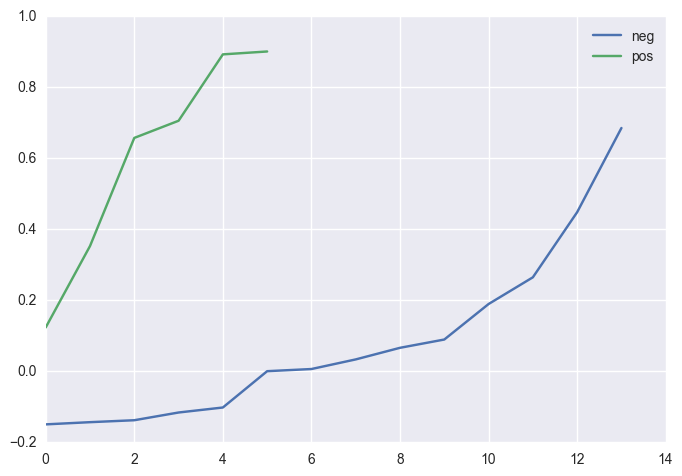

In [78]:
auroc_am_plsr = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, zero_train=False, 
                method='PLSR', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.25 


===== Training ======
Negative: 0.969 (31/32) 
Positive: 0.000 (0/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[0.029999999999999999, 0.089999999999999997, 0.089999999999999997, 0.11, 0.11, 0.13, 0.16, 0.17000000000000001, 0.19, 0.20999999999999999, 0.20999999999999999, 0.28000000000000003, 0.46999999999999997, 0.56000000000000005]
TPR: 0.929 (13/14) 
FPR: 0.500 (3/6) 
TPR: 0.929 (13/14) 
FPR: 0.667 (2/6) 


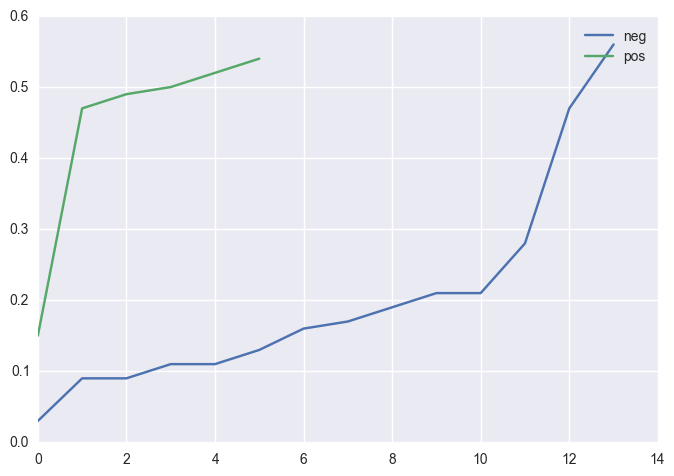

In [26]:
auroc_rf_am_100 = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.63 


===== Training ======
Negative: 0.812 (26/32) 
Positive: 0.000 (0/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[0.0, 0.0, 0.0, 0.0, 0.01, 0.029999999999999999, 0.040000000000000001, 0.089999999999999997, 0.14000000000000001, 0.20000000000000001, 0.27000000000000002, 0.28000000000000003, 0.42999999999999999, 0.55000000000000004]
TPR: 0.929 (13/14) 
FPR: 0.667 (2/6) 
TPR: 0.929 (13/14) 
FPR: 0.667 (2/6) 


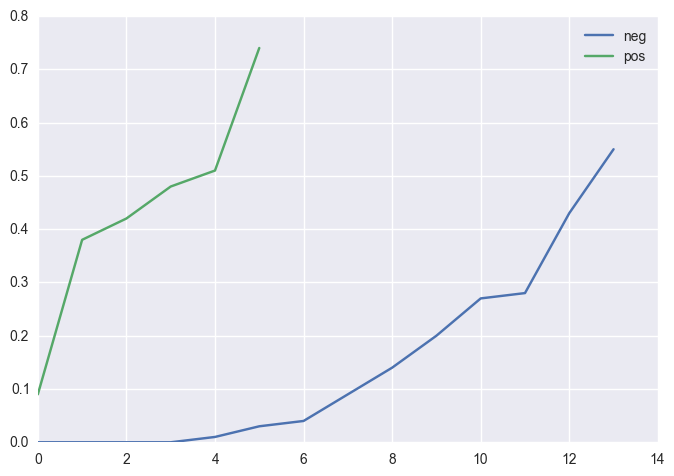

In [27]:
auroc_rf_am_11 = run_model(celltype='AM', response='original', n_top_genes=11, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.98 


===== Training ======
Negative: 0.594 (19/32) 
Positive: 0.000 (0/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.14000000000000001, 0.14999999999999999, 0.22, 0.37, 0.39000000000000001, 0.47999999999999998, 0.88]
TPR: 0.929 (13/14) 
FPR: 0.500 (3/6) 
TPR: 0.929 (13/14) 
FPR: 0.500 (3/6) 


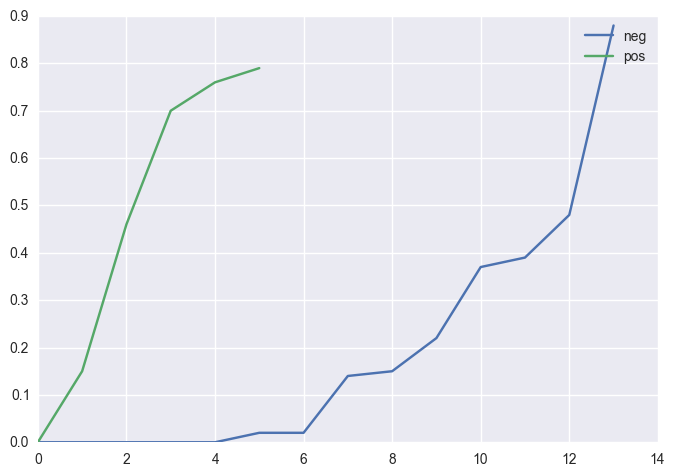

In [29]:
auroc_rf_am_5 = run_model(celltype='AM', response='original', n_top_genes=5, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

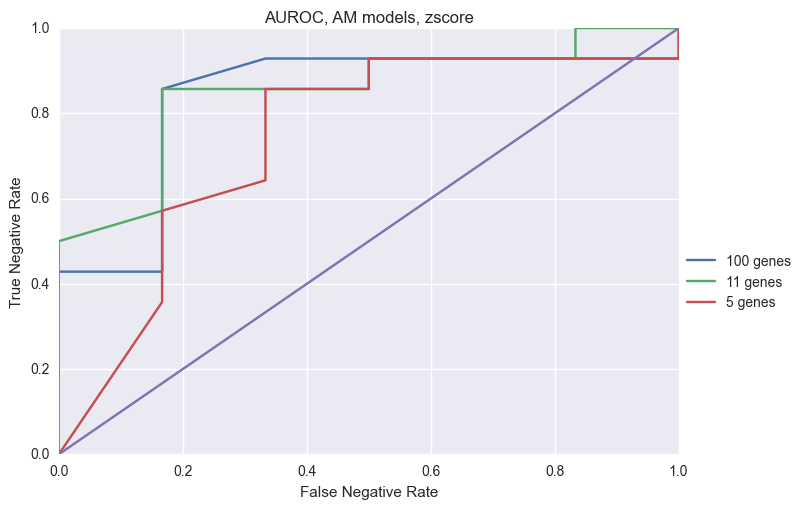

In [30]:
plt.plot(*zip(*auroc_rf_am_100), label='100 genes')
plt.plot(*zip(*auroc_rf_am_11), label='11 genes')
plt.plot(*zip(*auroc_rf_am_5), label='5 genes')
plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
plt.title("AUROC, AM models, zscore")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.legend(bbox_to_anchor=(1.2, 0.5))


### AM, no norm

Model =  AM
Method =  PLSR
Normalization =  None
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.63 


===== Training ======
Negative: 0.844 (27/32) 
Positive: 0.100 (1/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[array([ 0.13294493]), array([ 0.14366735]), array([ 0.15300342]), array([ 0.16014133]), array([ 0.16445396]), array([ 0.1706434]), array([ 0.17131138]), array([ 0.17570959]), array([ 0.17768558]), array([ 0.17893217]), array([ 0.18199931]), array([ 0.19016318]), array([ 0.1905738]), array([ 0.37933927])]
TPR: 1.000 ([14]/14) 
FPR: 1.000 ([0]/6) 
TPR: 1.000 ([14]/14) 
FPR: 1.000 ([0]/6) 


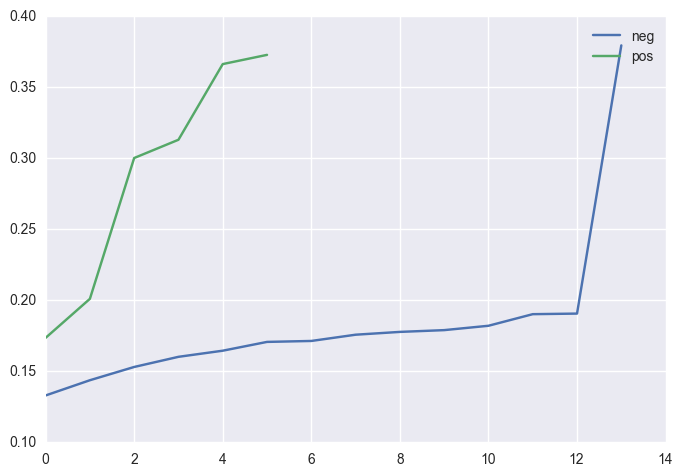

In [69]:
auroc_am_plsr_nonorm = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, zero_train=False, method='PLSR', 
                       norm=None, random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  None
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: -0.30 


===== Training ======
Negative: 0.938 (30/32) 
Positive: 0.000 (0/10) 
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====
predictions: 
[0.089999999999999997, 0.11, 0.11, 0.12, 0.14999999999999999, 0.14999999999999999, 0.14999999999999999, 0.16, 0.17000000000000001, 0.17000000000000001, 0.17999999999999999, 0.20999999999999999, 0.28999999999999998, 0.38]
TPR: 1.000 (14/14) 
FPR: 1.000 (0/6) 
TPR: 1.000 (14/14) 
FPR: 1.000 (0/6) 


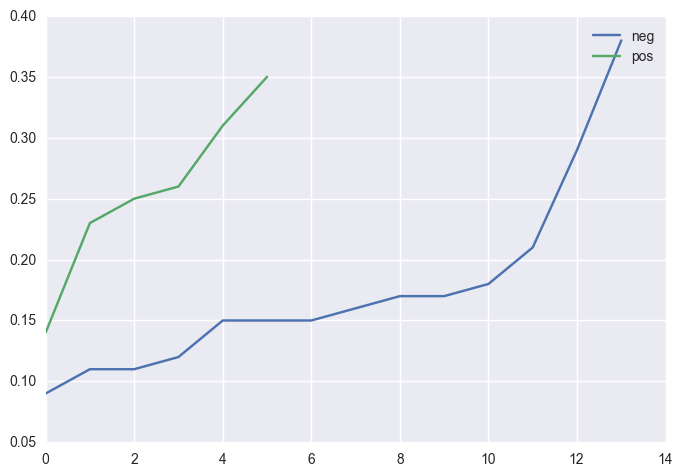

In [70]:
auroc_rf_am_nonorm = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm=None, random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

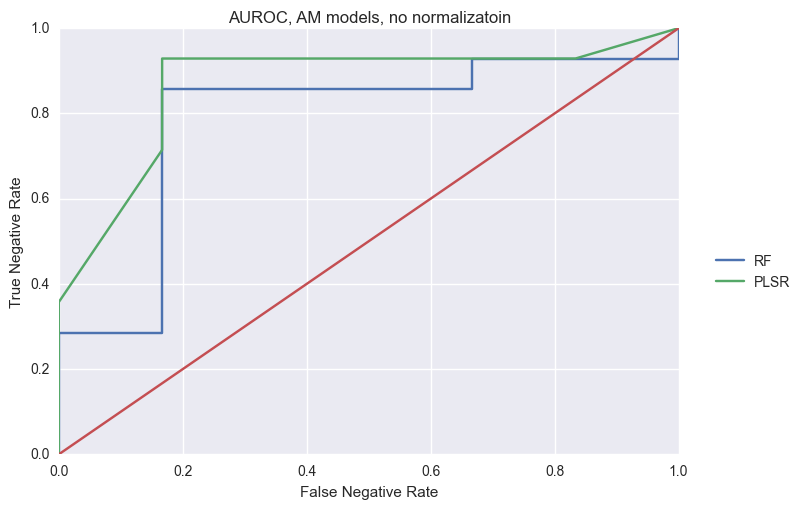

In [77]:
plt.plot(*zip(*auroc_rf_am_nonorm), label='RF')
plt.plot(*zip(*auroc_am_plsr_nonorm), label='PLSR')
plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
plt.title("AUROC, AM models, no normalizatoin")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.legend(bbox_to_anchor=(1.2, 0.5))


   ### CD163, PLSR

Model =  CD163
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: 0.27 


===== Training ======
Negative: 1.000 (32/32) 
Positive: 0.100 (1/10) 
Num pos after sampling: 7
Num neg after sampling: 4

===== Testing =====
predictions: 
[array([-0.02193222]), array([ 0.13708694]), array([ 0.19816419]), array([ 0.21925589])]
TPR: 1.000 ([4]/4) 
FPR: 0.571 ([3]/7) 
TPR: 1.000 ([4]/4) 
FPR: 0.571 ([3]/7) 


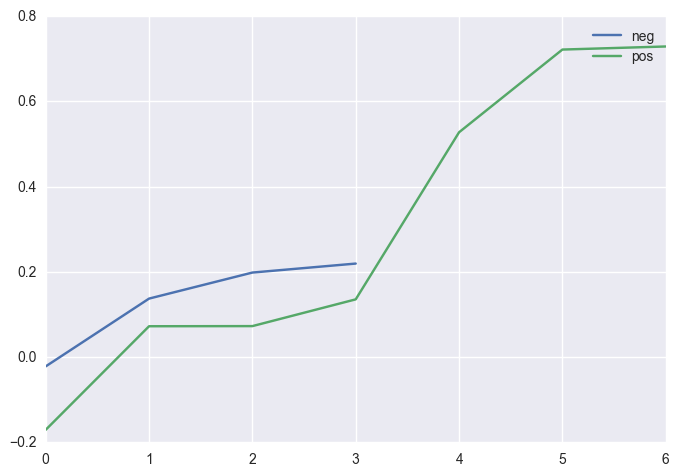

In [72]:
auroc_163_plsr_z = run_model(celltype='CD163', response='original', n_top_genes=100, jumble_train=False, zero_train=False, method='PLSR', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 10
Num neg after sampling: 32
Q Squared: 0.11 


===== Training ======
Negative: 0.969 (31/32) 
Positive: 0.100 (1/10) 
Num pos after sampling: 7
Num neg after sampling: 4

===== Testing =====
predictions: 
[0.050000000000000003, 0.12, 0.17000000000000001, 0.20999999999999999]
TPR: 1.000 (4/4) 
FPR: 0.714 (2/7) 
TPR: 1.000 (4/4) 
FPR: 0.714 (2/7) 


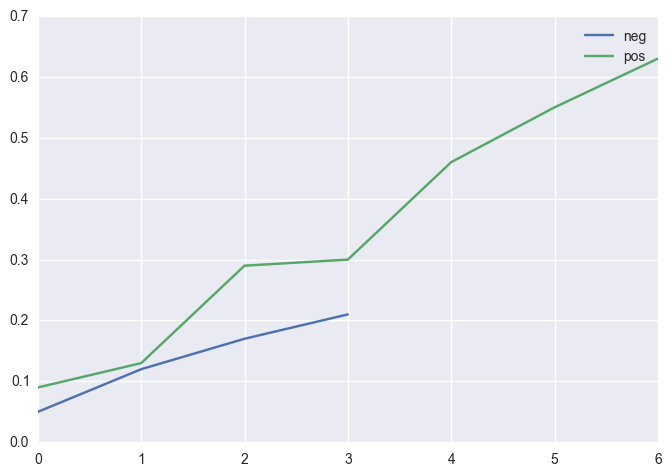

In [73]:
auroc_163_rf_z = run_model(celltype='CD163', response='original', n_top_genes=100, jumble_train=False, zero_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

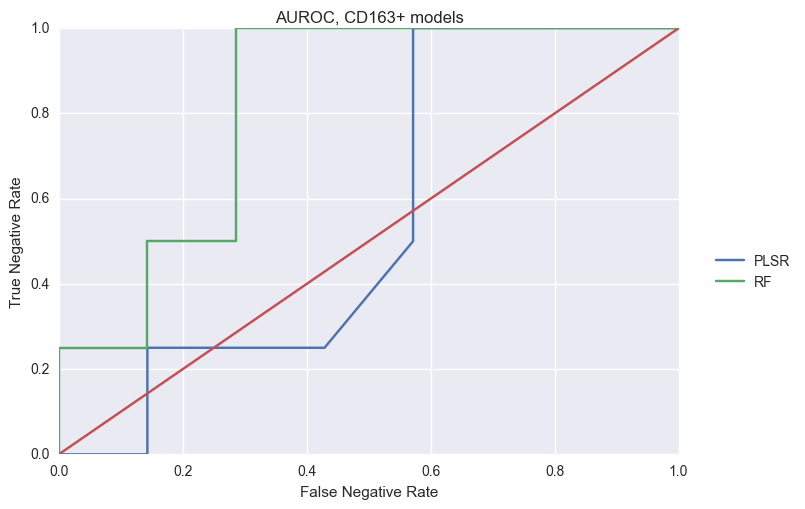

In [82]:
#plt.plot(*zip(*auroc_163_oral_PLSR), label='oral PLS')
plt.plot(*zip(*auroc_163_plsr_z), label='PLSR')
plt.plot(*zip(*auroc_163_rf_z), label='RF')
#plt.plot(*zip(*auroc_163_oral_RF), label='oral RF')
#plt.plot(*zip(*auroc_163_RF), label='RF')
plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
plt.title("AUROC, CD163+ models")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.legend(bbox_to_anchor=(1.2, 0.5))

## Train clustering

In [158]:
celltype='AM'
norm='zscore'
sampling=''
X, y, genes, df, dfm = geteven_xy(train_fpkm, train_meta, celltype=celltype, norm=norm, sampling=sampling)

Num pos after sampling: 15
Num neg after sampling: 34


## Test clustering

## +++++

In [156]:
def plot_cluster(df, dfm):
    
    dfz = df.apply(zscore, axis=1)
    dfz = dfz.apply(zscore, axis=0)
    dfplot = dfz.T

    dfplot = dfplot.rename(columns={c: dfm.loc[c,'Pneum'] for c in dfplot.columns})

    dfplot.columns
    fig = sns.clustermap(dfplot, col_cluster=True)

In [ ]:
#determine the best number of genes for the training model
def plotQ2(r=np.arange(10,205,5), celltype=False, z=True):
    Q2s = []
    for n_top_genes in tqdm(r):
        X, y, genes, df, dfm = geteven_xy(train_fpkm, meta, celltype=celltype, norm='zscore')
        neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
        Q2s.append(Q2)
    plt.plot(r, Q2s)
    return None #Q2s

In [ ]:
plotQ2(r=np.arange(10,155,10), celltype='AM')

In [ ]:
plotQ2(r=np.arange(10,155,5), celltype='CD163')

In [62]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [25]:
def calc_Q2_kftest(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestRegressor()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]